# Visualizing latent space with t-SNE

## Initialization

In [1]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *
from geomloss import SamplesLoss
from skopt import gp_minimize
import torchvision
import kornia as K

In [2]:
%%capture
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',50,modality='t2')
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',50,modality='t2')
brats_train_loader, brats_test_loader, brats_val_loader = get_dataloader('brats',50,modality='t2')

In [4]:
%%capture 
model_dhcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_dhcp_t2/1600.pth')
model_hcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_hcp_t2/520.pth')
model_brats = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_brats_t2/1570.pth')
model_dhcp = model_dhcp.cuda()
model_hcp = model_hcp.cuda()
model_brats = model_brats.cuda()
model_dhcp.eval()
model_hcp.eval()
model_brats.eval()
model = model_dhcp

In [5]:
latent_dhcp = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp.pt')
latent_hcp = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp.pt')
latent_brown = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brown.pt')
latent_brown_opti = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brown_opti.pt')
latent_dhcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_val.pt')
latent_hcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_val.pt')

# t-SNE

## dHCP-HCP

In [60]:
labels = np.zeros(latent_dhcp.shape[0]+latent_hcp.shape[0])
labels[latent_dhcp.shape[0]:] = 1

In [82]:
## t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("paper", font_scale=1.5,
                rc={"lines.linewidth": 2.5})    

# latent = torch.cat([latent_dhcp,latent_hcp,latent_brown],dim=0)
latent = torch.cat([latent_dhcp,latent_hcp],dim=0)
latent = latent.flatten(start_dim=1)
latent = latent.cpu().numpy()
tsne = TSNE(n_components=2)
latent_embedded = tsne.fit_transform(latent)

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [84]:
tsne.__dict__()

{'n_components': 2,
 'perplexity': 30.0,
 'early_exaggeration': 12.0,
 'learning_rate': 'warn',
 'n_iter': 1000,
 'n_iter_without_progress': 300,
 'min_grad_norm': 1e-07,
 'metric': 'euclidean',
 'init': 'warn',
 'verbose': 0,
 'random_state': None,
 'method': 'barnes_hut',
 'angle': 0.5,
 'n_jobs': None,
 'square_distances': 'legacy',
 '_init': 'random',
 '_learning_rate': 200.0,
 'n_features_in_': 256000,
 'n_iter_': 999,
 'kl_divergence_': 1.3924572467803955,
 'embedding_': array([[-35.342857 ,  -0.8021058],
        [-43.302074 ,  -1.9667938],
        [-47.134155 , -12.072887 ],
        ...,
        [ 30.300339 ,  -3.84073  ],
        [ 45.44452  ,   4.5526037],
        [ 37.435223 ,   6.8679833]], dtype=float32)}

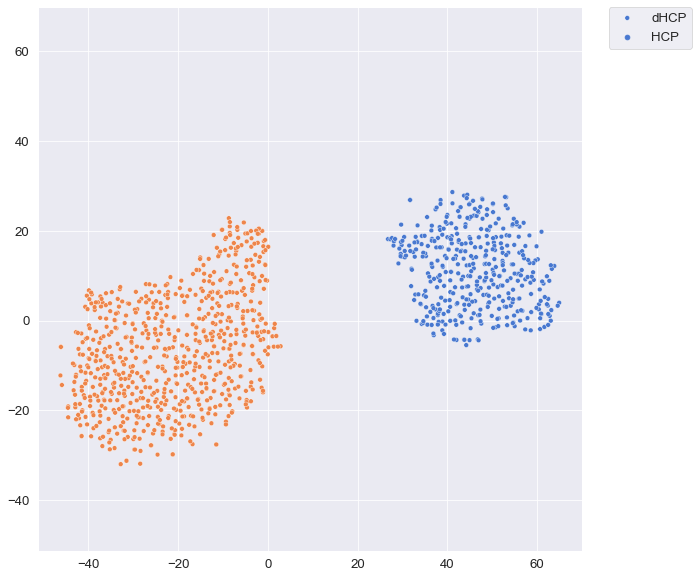

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=latent_embedded[:,0],y=latent_embedded[:,1],hue=labels,ax=ax)
lim = (latent_embedded.min()-5, latent_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(['dHCP','HCP'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('tsne.svg',bbox_inches='tight')

## dHCP-HCP-dHCP val

In [89]:
labels = np.zeros(latent_dhcp.shape[0]+latent_hcp.shape[0]+ latent_dhcp_val.shape[0])
labels[latent_dhcp.shape[0]:latent_dhcp.shape[0]+latent_hcp.shape[0]] = 1
labels[latent_dhcp.shape[0]+latent_hcp.shape[0]:] = 2

In [90]:
## t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("paper", font_scale=1.5,
                rc={"lines.linewidth": 2.5})    

# latent = torch.cat([latent_dhcp,latent_hcp,latent_brown],dim=0)
latent = torch.cat([latent_dhcp,latent_hcp, latent_dhcp_val],dim=0)
latent = latent.flatten(start_dim=1)
latent = latent.cpu().numpy()
latent_embedded = TSNE(n_components=2).fit_transform(latent)

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



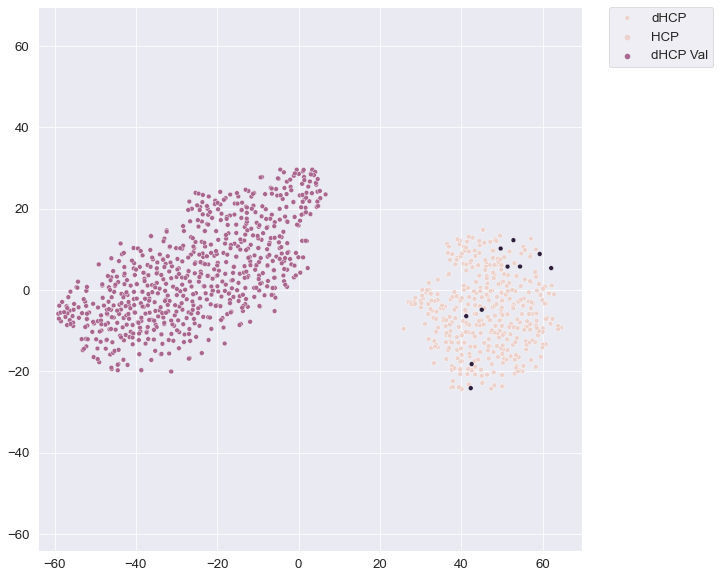

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=latent_embedded[:,0],y=latent_embedded[:,1],hue=labels,ax=ax)
lim = (latent_embedded.min()-5, latent_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(['dHCP','HCP', 'dHCP Val'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('tsne.svg',bbox_inches='tight')

## dHCP-HCP-BROWN

In [64]:
labels = np.zeros(latent_dhcp.shape[0]+latent_hcp.shape[0]+latent_brown.shape[0])
labels[latent_dhcp.shape[0]:latent_dhcp.shape[0]+latent_hcp.shape[0]] = 1
labels[latent_dhcp.shape[0]+latent_hcp.shape[0]:] = 2

In [65]:
## t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("paper", font_scale=1.5,
                rc={"lines.linewidth": 2.5})    

latent = torch.cat([latent_dhcp,latent_hcp, latent_brown],dim=0)
latent = latent.flatten(start_dim=1)
latent = latent.cpu().numpy()
latent_embedded = TSNE(n_components=2).fit_transform(latent)

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



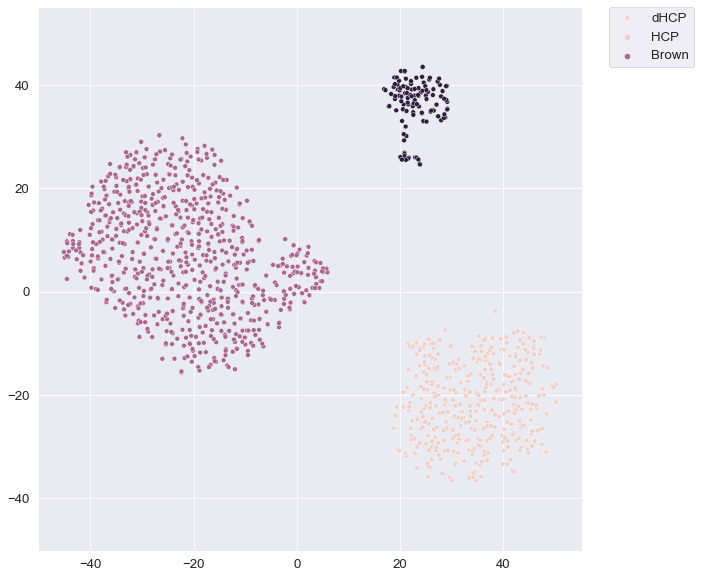

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=latent_embedded[:,0],y=latent_embedded[:,1],hue=labels,ax=ax)
lim = (latent_embedded.min()-5, latent_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(['dHCP','HCP','Brown'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('tsne.svg',bbox_inches='tight')

## dHCP-HCP-BROWN-BROWN Optimized

In [68]:
labels = np.zeros(latent_dhcp.shape[0]+latent_hcp.shape[0]+latent_brown.shape[0]+latent_brown_opti.shape[0])
labels[latent_dhcp.shape[0]:latent_dhcp.shape[0]+latent_hcp.shape[0]] = 1
labels[latent_dhcp.shape[0]+latent_hcp.shape[0]:latent_dhcp.shape[0]+latent_hcp.shape[0]+latent_brown.shape[0]] = 2
labels[latent_dhcp.shape[0]+latent_hcp.shape[0]+latent_brown.shape[0]:] = 3

In [69]:
## t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("paper", font_scale=1.5,
                rc={"lines.linewidth": 2.5})    

# latent = torch.cat([latent_dhcp,latent_hcp,latent_brown],dim=0)
latent = torch.cat([latent_dhcp,latent_hcp, latent_brown, latent_brown_opti],dim=0)
latent = latent.flatten(start_dim=1)
latent = latent.cpu().numpy()
latent_embedded = TSNE(n_components=2).fit_transform(latent)

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



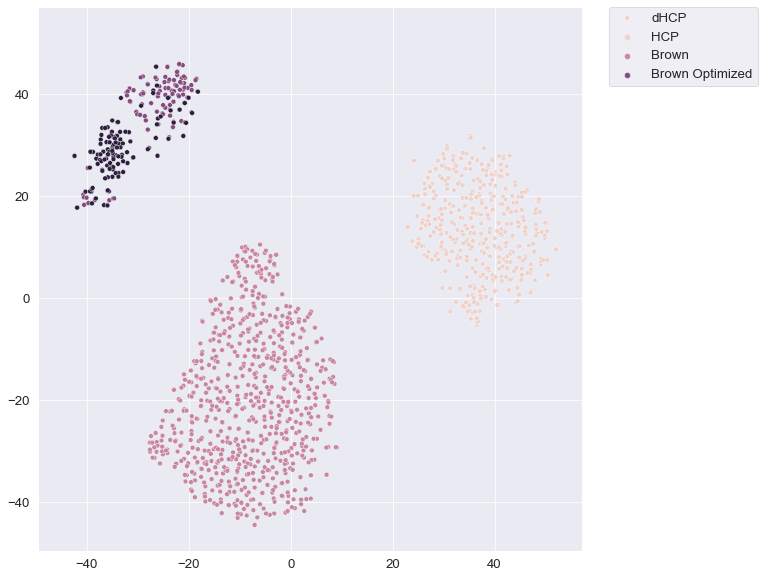

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=latent_embedded[:,0],y=latent_embedded[:,1],hue=labels,ax=ax)
lim = (latent_embedded.min()-5, latent_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(['dHCP','HCP', 'Brown', 'Brown Optimized'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('tsne.svg',bbox_inches='tight')

# Generate Latents

In [ ]:
images = []
image_tensors = []
t2_file_list = os.listdir('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_BROWN/input_raw/')
t2_file_list = [os.path.join('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_BROWN/input_raw/',x) for x in t2_file_list]
for t2_file in tqdm(t2_file_list,total=len(t2_file_list)):
    images.append(sitk.ReadImage(t2_file))
    subject = tio.Subject(t2=tio.ScalarImage(t2_file))
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.ToCanonical(),
        tio.transforms.Resample((1.,1.,1.)),
    ])
    subject = transform_1(subject)
    edge_max = max(subject.t2.data.shape)
    padding = ((edge_max - subject.t2.data.shape[1]) // 2, 
                (edge_max - subject.t2.data.shape[2]) // 2,
                    (edge_max - subject.t2.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)
    image_tensor = subject.t2.data.unsqueeze(0).float()
    image_tensors.append(image_tensor)

  0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
latent_dhcp = []
for img,gt in tqdm(dhcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'latent_dhcp.pt')
latent_hcp = []
for img,gt in tqdm(hcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'latent_hcp.pt')
latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'latent_brown.pt')

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/712 [00:00<?, ?it/s]

In [87]:
latent_dhcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_val.pt')
latent_hcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_val.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Schematic of Wasserstein

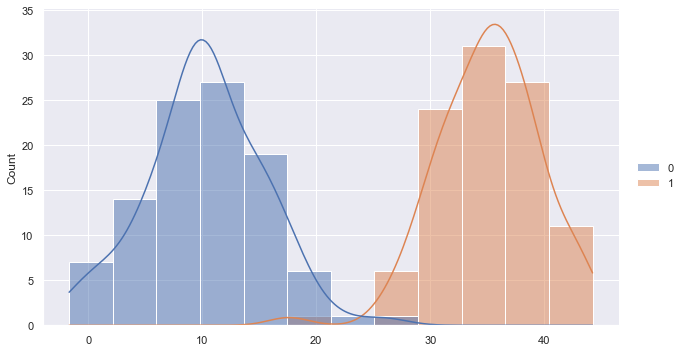

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
sns.plotting_context('talk')

x1 = np.random.normal(10, 5, 100)
x2 = np.random.normal(35, 5, 100)

x = np.stack((x1, x2), axis=1)

sns.displot(x, aspect=16/9, bins=12, kde=True)
plt.savefig('wasserstein_sched.svg',bbox_inches='tight')

# Quantitative Evaluation

In [26]:
model_dhcp = model
model_hcp = torch.load('/media/hdd/viscent/SR-UNet/pretrained_models/unet_hcp_t2/600.pth')

In [24]:
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',modality='t2')
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',modality='t2')

[11/23/22 09:37:25] INFO     colossalai - root - INFO: Creating dataset with 510 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 510

  0%|          | 0/510 [00:00<?, ?it/s]

[11/23/22 09:39:26] INFO     colossalai - root - INFO: Creating dataset with 127 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 128

  0%|          | 0/127 [00:00<?, ?it/s]

[11/23/22 09:39:58] INFO     colossalai - root - INFO: Creating dataset with 890 examples

  0%|          | 0/890 [00:00<?, ?it/s]

[11/23/22 09:43:34] INFO     colossalai - root - INFO: Creating dataset with 222 examples

  0%|          | 0/222 [00:00<?, ?it/s]

In [25]:
from scipy.stats import ttest_ind

## dHCP-dHCP

In [92]:
sinkhorn_dhcp_dhcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_input = kl_forward_latent(model_dhcp,img)
        latent_input = latent_input.flatten().unsqueeze(0)
        latent_train = latent_dhcp.flatten(start_dim=1)
        loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
        sinkhorn_dhcp_dhcp.append(loss.item())
sinkhorn_dhcp_dhcp = np.array(sinkhorn_dhcp_dhcp)

  0%|          | 0/10 [00:00<?, ?it/s]

## dHCP-HCP

In [28]:
sinkhorn_dhcp_hcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_input = kl_forward_latent(model_hcp,img)
        latent_input = latent_input.flatten().unsqueeze(0)
        latent_train = latent_hcp.flatten(start_dim=1)
        loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
        sinkhorn_dhcp_hcp.append(loss.item())
sinkhorn_dhcp_hcp = np.array(sinkhorn_dhcp_hcp)

  0%|          | 0/127 [00:00<?, ?it/s]

## HCP-HCP

In [33]:
sinkhorn_hcp_hcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_input = kl_forward_latent(model_hcp,img)
        latent_input = latent_input.flatten().unsqueeze(0)
        latent_train = latent_hcp.flatten(start_dim=1)
        loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
        sinkhorn_hcp_hcp.append(loss.item())
sinkhorn_hcp_hcp = np.array(sinkhorn_hcp_hcp)

  0%|          | 0/222 [00:00<?, ?it/s]

## HCP-dHCP

In [93]:
sinkhorn_hcp_dhcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_input = kl_forward_latent(model_dhcp,img)
        latent_input = latent_input.flatten().unsqueeze(0)
        latent_train = latent_dhcp.flatten(start_dim=1)
        loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
        sinkhorn_hcp_dhcp.append(loss.item())
sinkhorn_hcp_dhcp = np.array(sinkhorn_hcp_dhcp)

  0%|          | 0/10 [00:00<?, ?it/s]

## Visualization

p-value:  4.896488176156836e-07 *


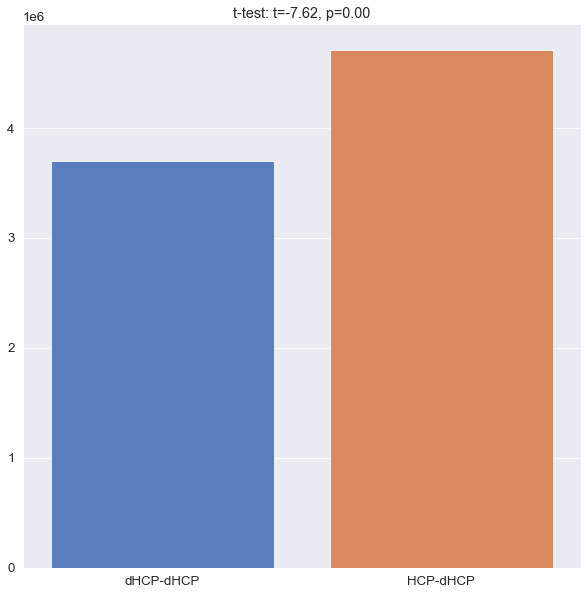

In [94]:
sns.barplot(x=['dHCP-dHCP','HCP-dHCP'],y=[sinkhorn_dhcp_dhcp.mean(),sinkhorn_hcp_dhcp.mean()])
ttest_dhcp_model = ttest_ind(sinkhorn_dhcp_dhcp,sinkhorn_hcp_dhcp)
plt.title('t-test: t=%.2f, p=%.2f'%(ttest_dhcp_model.statistic,ttest_dhcp_model.pvalue))
if ttest_dhcp_model.pvalue < 0.05:
    print('p-value: ',ttest_dhcp_model.pvalue,'*')
else:
    print('p-value: ',ttest_dhcp_model.pvalue)

p-value:  9.930080882775916e-36 *


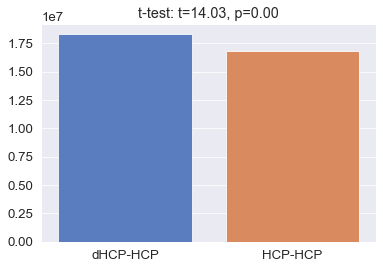

In [45]:
sns.barplot(x=['dHCP-HCP','HCP-HCP'],y=[sinkhorn_dhcp_hcp.mean(),sinkhorn_hcp_hcp.mean()])
ttest_hcp_model = ttest_ind(sinkhorn_dhcp_hcp,sinkhorn_hcp_hcp)
plt.title('t-test: t=%.2f, p=%.2f'%(ttest_hcp_model.statistic,ttest_hcp_model.pvalue))
if ttest_hcp_model.pvalue < 0.05:
    print('p-value: ',ttest_hcp_model.pvalue,'*')
else:
    print('p-value: ',ttest_hcp_model.pvalue)

# Inference Example

In [6]:
plt.rcParams['figure.figsize'] = [10, 10]

### dHCP Model

<Figure size 1440x720 with 0 Axes>

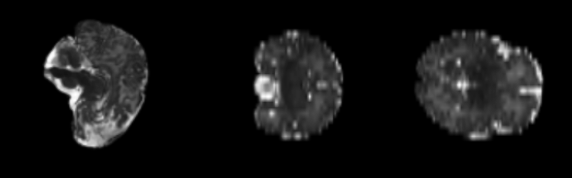

<Figure size 1440x720 with 0 Axes>

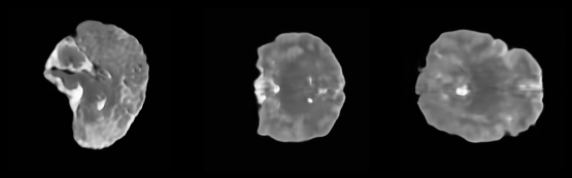

<Figure size 1440x720 with 0 Axes>

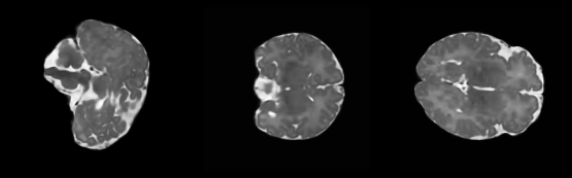

<Figure size 1440x720 with 0 Axes>

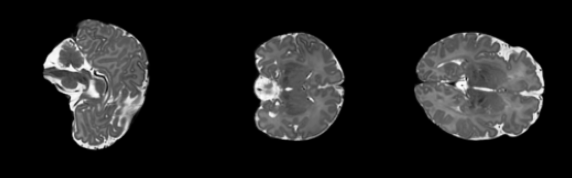

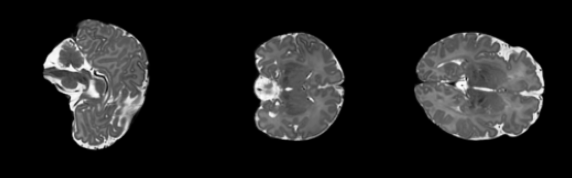

In [7]:
img,gt = iter(dhcp_val_loader).next()
img = img.cuda()
with torch.no_grad():
    pred = model_dhcp(img)
    pred_bad = model_hcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())

### HCP Model

<Figure size 1440x720 with 0 Axes>

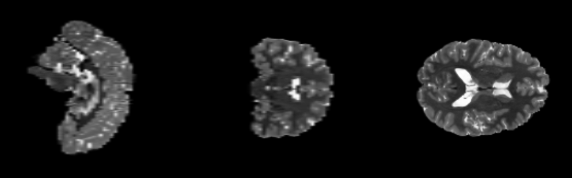

<Figure size 1440x720 with 0 Axes>

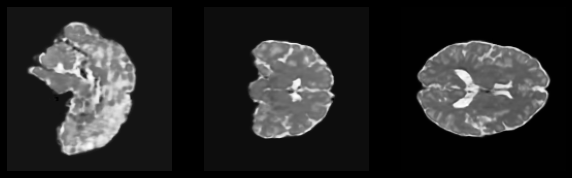

<Figure size 1440x720 with 0 Axes>

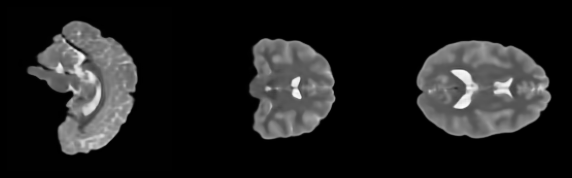

<Figure size 1440x720 with 0 Axes>

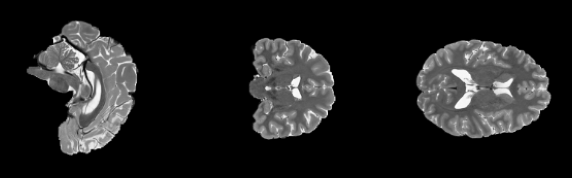

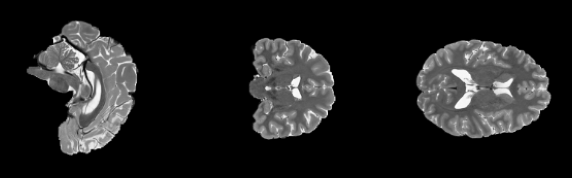

In [8]:
img,gt = iter(hcp_val_loader).next()
img = img.cuda()
with torch.no_grad():
    pred = model_hcp(img)
    pred_bad = model_dhcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())

### BraTS Model

<Figure size 1440x720 with 0 Axes>

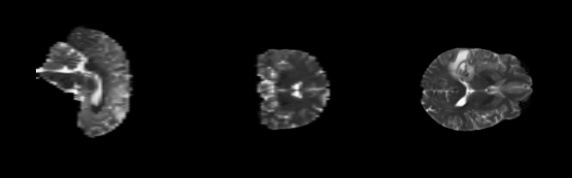

<Figure size 1440x720 with 0 Axes>

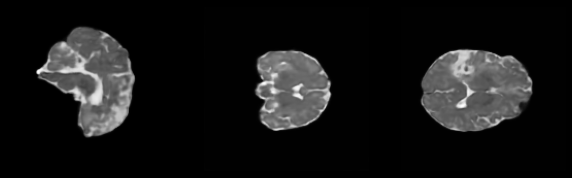

<Figure size 1440x720 with 0 Axes>

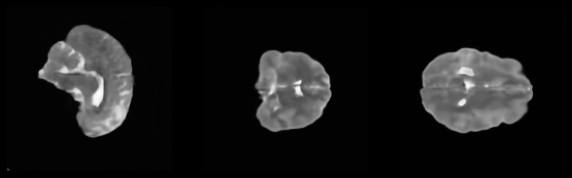

<Figure size 1440x720 with 0 Axes>

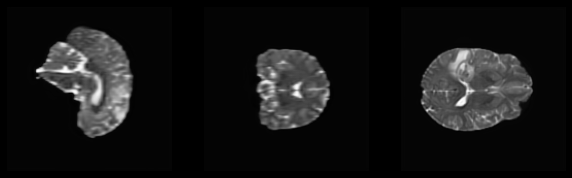

<Figure size 1440x720 with 0 Axes>

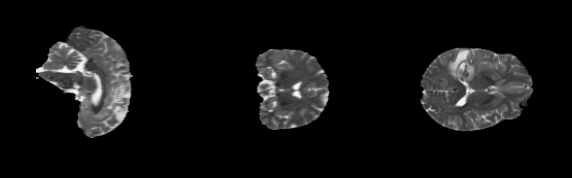

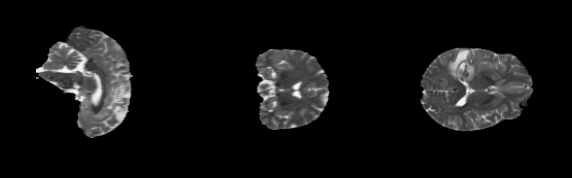

In [9]:
img,gt = iter(brats_test_loader).next()   
img = img.cuda()
with torch.no_grad():
    pred = model_brats(img)
    pred_bad = model_hcp(img)
    pred_worse = model_dhcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_worse[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())